### 本コードで実施していること

- LSTMを用いた学習・テスト
  - 目的関数、説明関数ともに終値の場合

使用するライブラリのインポート

In [1]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
# CSVファイルの読み込み
df = pd.read_csv('../stock_price.csv')

#### 目的関数・説明関数ともに終値の場合

目的変数(`終値`)の正規化

In [3]:
# 終値のデータを抽出
data = df.filter(['終値']).values.reshape(-1, 1)

学習データとテストデータの確認

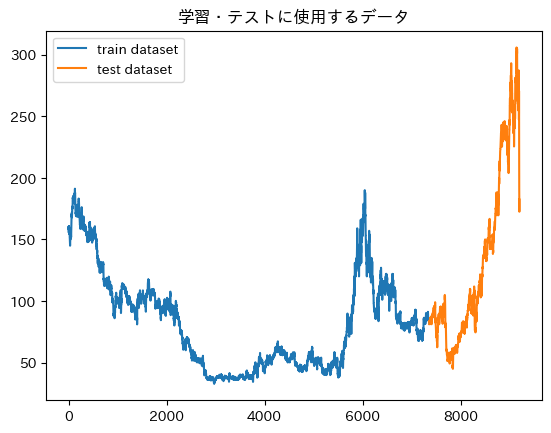

In [4]:
# 学習データとテストデータの分割
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# 学習データとテストデータの可視化
fig, ax = plt.subplots()
ax.plot(range(len(train_data)), train_data, label="train dataset")
ax.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label="test dataset")
plt.legend()
plt.title("学習・テストに使用するデータ")
plt.show()

データの正規化

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data =  scaler.fit_transform(data)

train_data = data[:train_size]
test_data = data[train_size:]

データをLSTMの入力形式に変換

In [6]:
# データをLSTMの入力形式に変換
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

In [7]:
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# LSTMの入力形式にデータにリシェイプ
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

LSTMモデルの構築・訓練・テスト

In [8]:
def train_lstm(X_train, y_train, batch_size, epochs):

    # モデルの構築
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(Dense(16))
    model.add(Dense(1))  

    # モデルのコンパイル
    model.compile(optimizer='adam', loss='mean_squared_error')

    # モデルの訓練
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
    
    return model

In [9]:
model, history = train_lstm(X_train, y_train, batch_size=16, epochs=50)

Epoch 1/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 2214.0093
Epoch 2/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 53.5116
Epoch 3/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 41.3270
Epoch 4/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 40.6647
Epoch 5/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 36.1115
Epoch 6/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 35.2957
Epoch 7/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 34.7716
Epoch 8/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 36.0281
Epoch 9/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 32.4897
Epoch 10/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 30.3504
Epoch 11/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 31.7450
Epoch 12/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 34.0305
Epoch 13/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 29.2123
Epoch 14/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 25.6272
Epoch 15/50
4

過学習の確認

In [ ]:
# 訓練データと検証データの損失をプロット
def plot_loss(history):
    plt.figure(figsize=(14, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('訓練データと検証データの損失')
    plt.xlabel('エポック')
    plt.ylabel('損失')
    plt.legend()
    plt.show()

In [ ]:
plot_loss(history)

テストデータを使った予測・結果のプロット

In [10]:
def test_plot(X_test, y_test, scaler):

    # テストデータを使った予測
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    # 結果の表示
    print(predictions)

    # 実際の終値のスケールを元に戻す
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    mae = mean_absolute_error(y_test_actual, predictions)
    print(f'Mean Absolute Error (MAE): {mae}')

    # 実際の終値と予測値のプロット
    plt.figure(figsize=(14, 5))
    plt.plot(y_test_actual, color='blue', label='Actual Stock Price')
    plt.plot(predictions, color='red', label='Predicted Stock Price')
    plt.title('LSTMによる株価予測')
    plt.xlabel('時間')
    plt.ylabel('株価')
    plt.legend()
    plt.show()

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
[[22954.844]
 [23170.979]
 [23116.959]
 ...
 [48458.38 ]
 [47530.547]
 [46433.832]]
Mean Absolute Error (MAE): 4291.600819880869


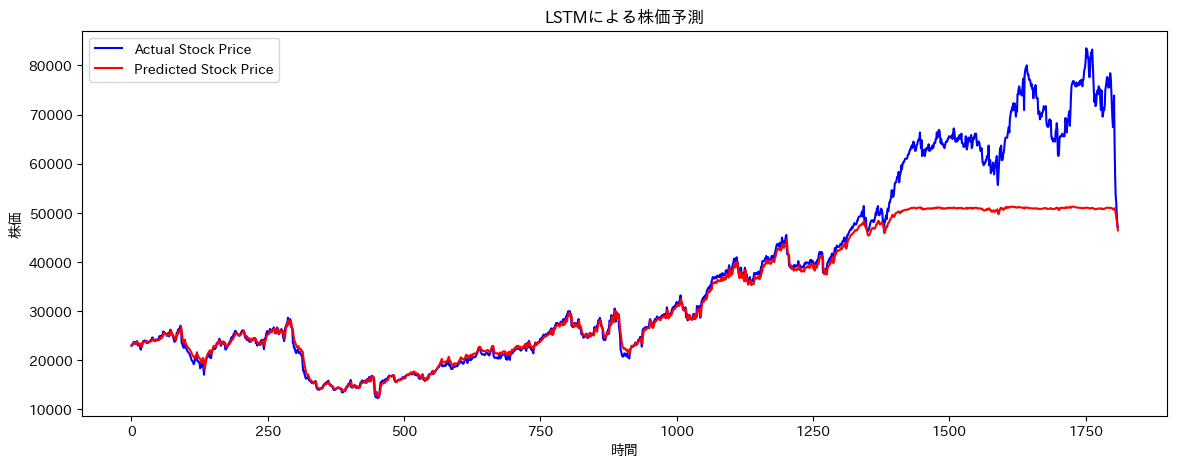

In [11]:
test_plot(X_test, y_test, scaler)